In [2]:
from PIL import Image
import os
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
import numpy as np
import cv2
from skimage import exposure
from skimage.transform import resize
from skimage.feature import local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from xgboost import XGBClassifier
import pickle
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import LabelEncoder

c:\Users\ASUS\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
import warnings
warnings.filterwarnings("ignore")

### 1. Perform EDA

In [54]:
image_folder = 'data'

In [4]:
label_path = 'label.csv'
label_df = pd.read_csv(label_path)
label_df.head()

filename         label
0  Image_1.jpg       sitting
1  Image_2.jpg  using_laptop
2  Image_3.jpg       hugging
3  Image_4.jpg      sleeping
4  Image_5.jpg  using_laptop

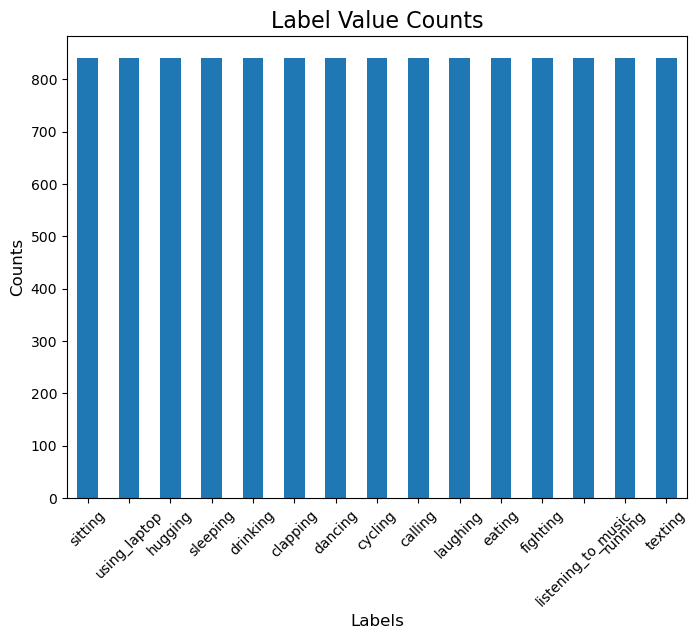

In [5]:
label_counts = label_df['label'].value_counts()

plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar')

plt.title('Label Value Counts', fontsize=16)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Counts', fontsize=12)

plt.xticks(rotation=45)
plt.show()

We notice that there are 840 images in each class.

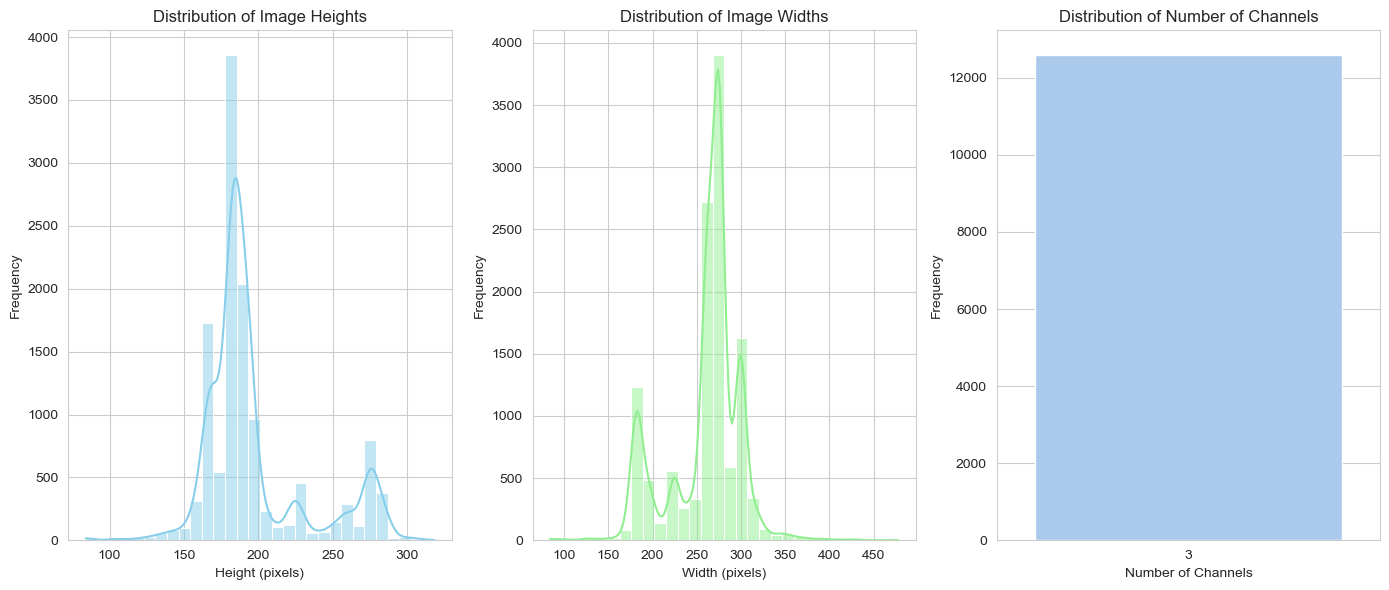

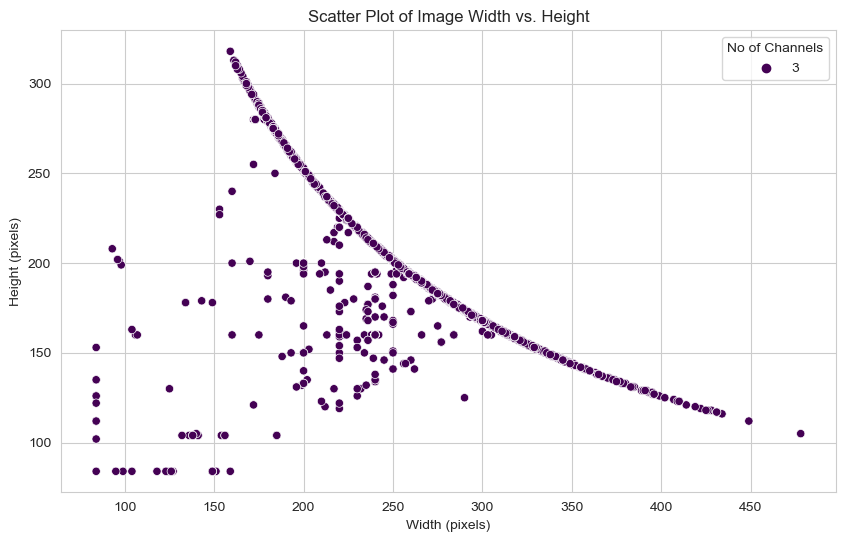

In [8]:
sns.set_style('whitegrid')

# Plotting distribution of image heights
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
sns.histplot(label_df['height'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

# Plotting distribution of image widths
plt.subplot(1, 3, 2)
sns.histplot(label_df['width'], bins=30, kde=True, color='lightgreen')
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

# Plotting distribution of number of channels
plt.subplot(1, 3, 3)
sns.countplot(x='channels', data=label_df, palette='pastel')
plt.title('Distribution of Number of Channels')
plt.xlabel('Number of Channels')
plt.ylabel('Frequency')

# Displaying the plots
plt.tight_layout()
plt.show()

# Visualize relationship between height and width with a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='width', y='height', hue='channels', data=label_df, palette='viridis')
plt.title('Scatter Plot of Image Width vs. Height')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.legend(title='No of Channels')
plt.show()

We notice that the height and width follows a nearly normal distribution. The number of channels in each image is 3. The height and width follows an inverse relationship, that is when the width increases, the height decreases.

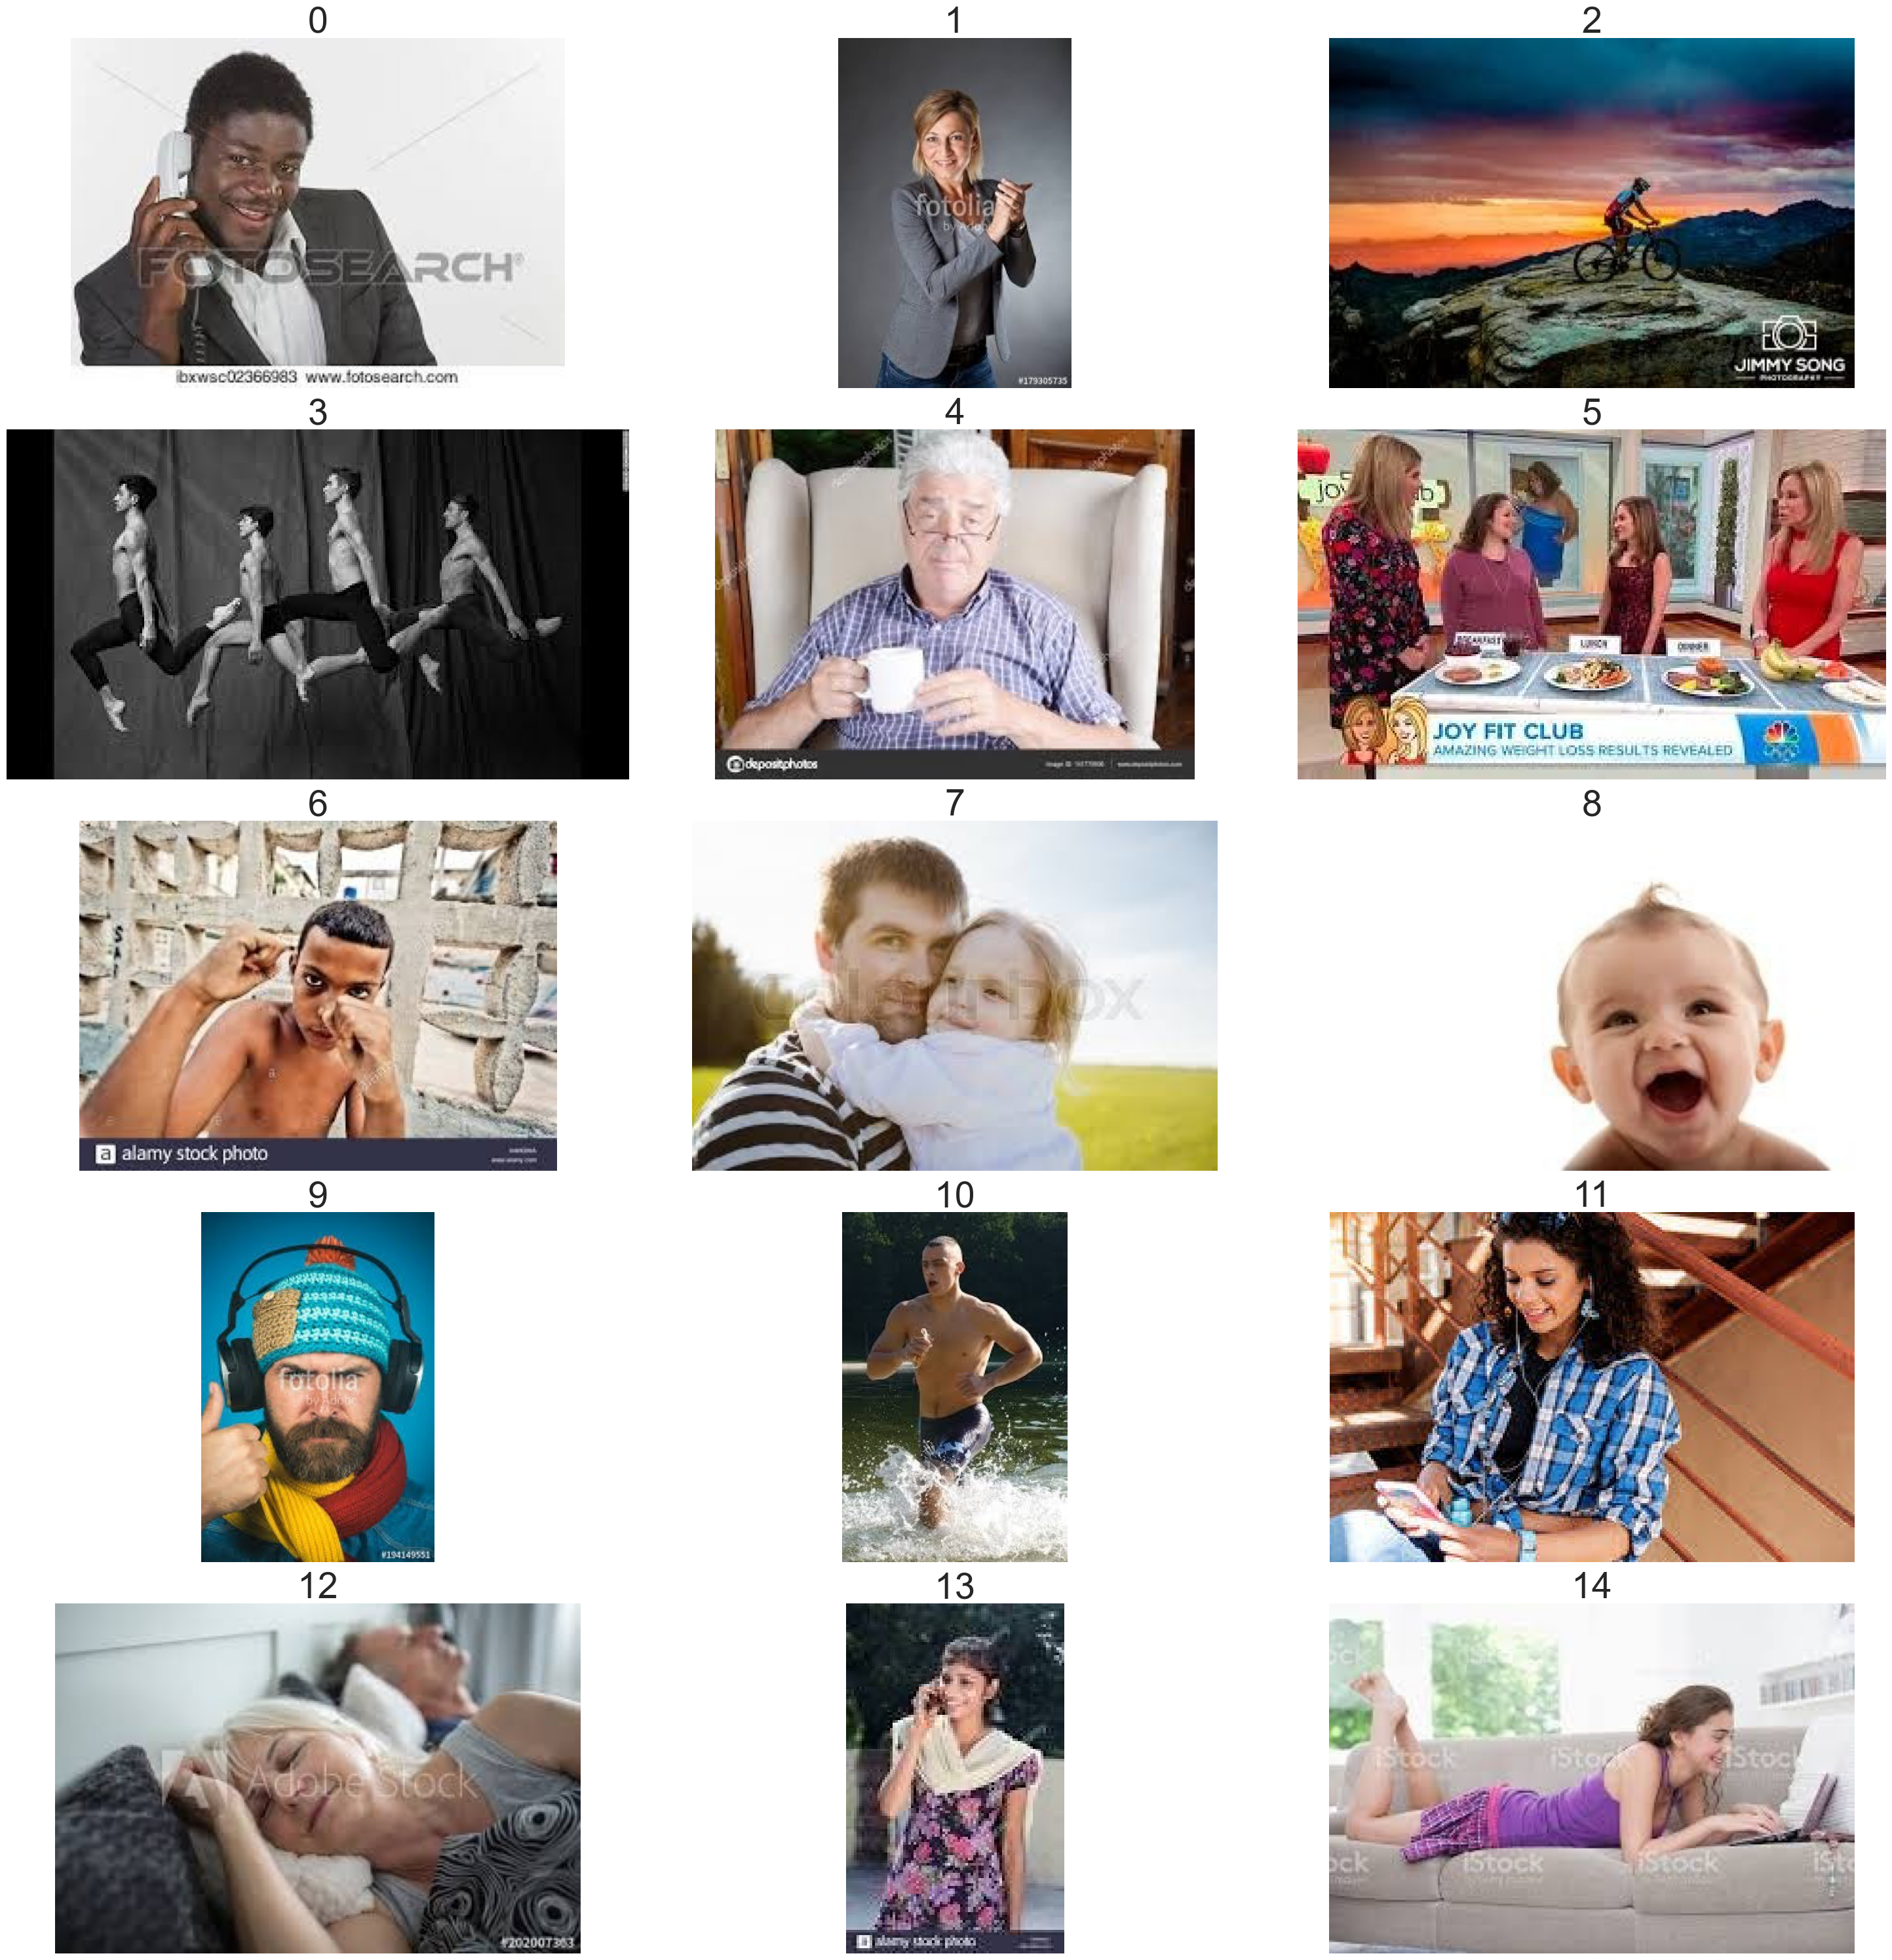

In [55]:
images = []

class_image = label_df.groupby('label').first().reset_index()
plt.figure(figsize=(30, 30))

for idx, row in class_image.iterrows():
    image_path = row['filename']
    label = row['label']
    img = Image.open(os.path.join(image_folder, image_path))
    images.append(img)
    plt.subplot(5, 3, idx + 1)
    plt.imshow(img)
    plt.title(label, fontsize = 40)
    plt.axis('off')

plt.tight_layout()
plt.show()

We notice that the relationship between height and width is verified as we can notice from these pictures that as the width increases, the height decreases and vice versa.

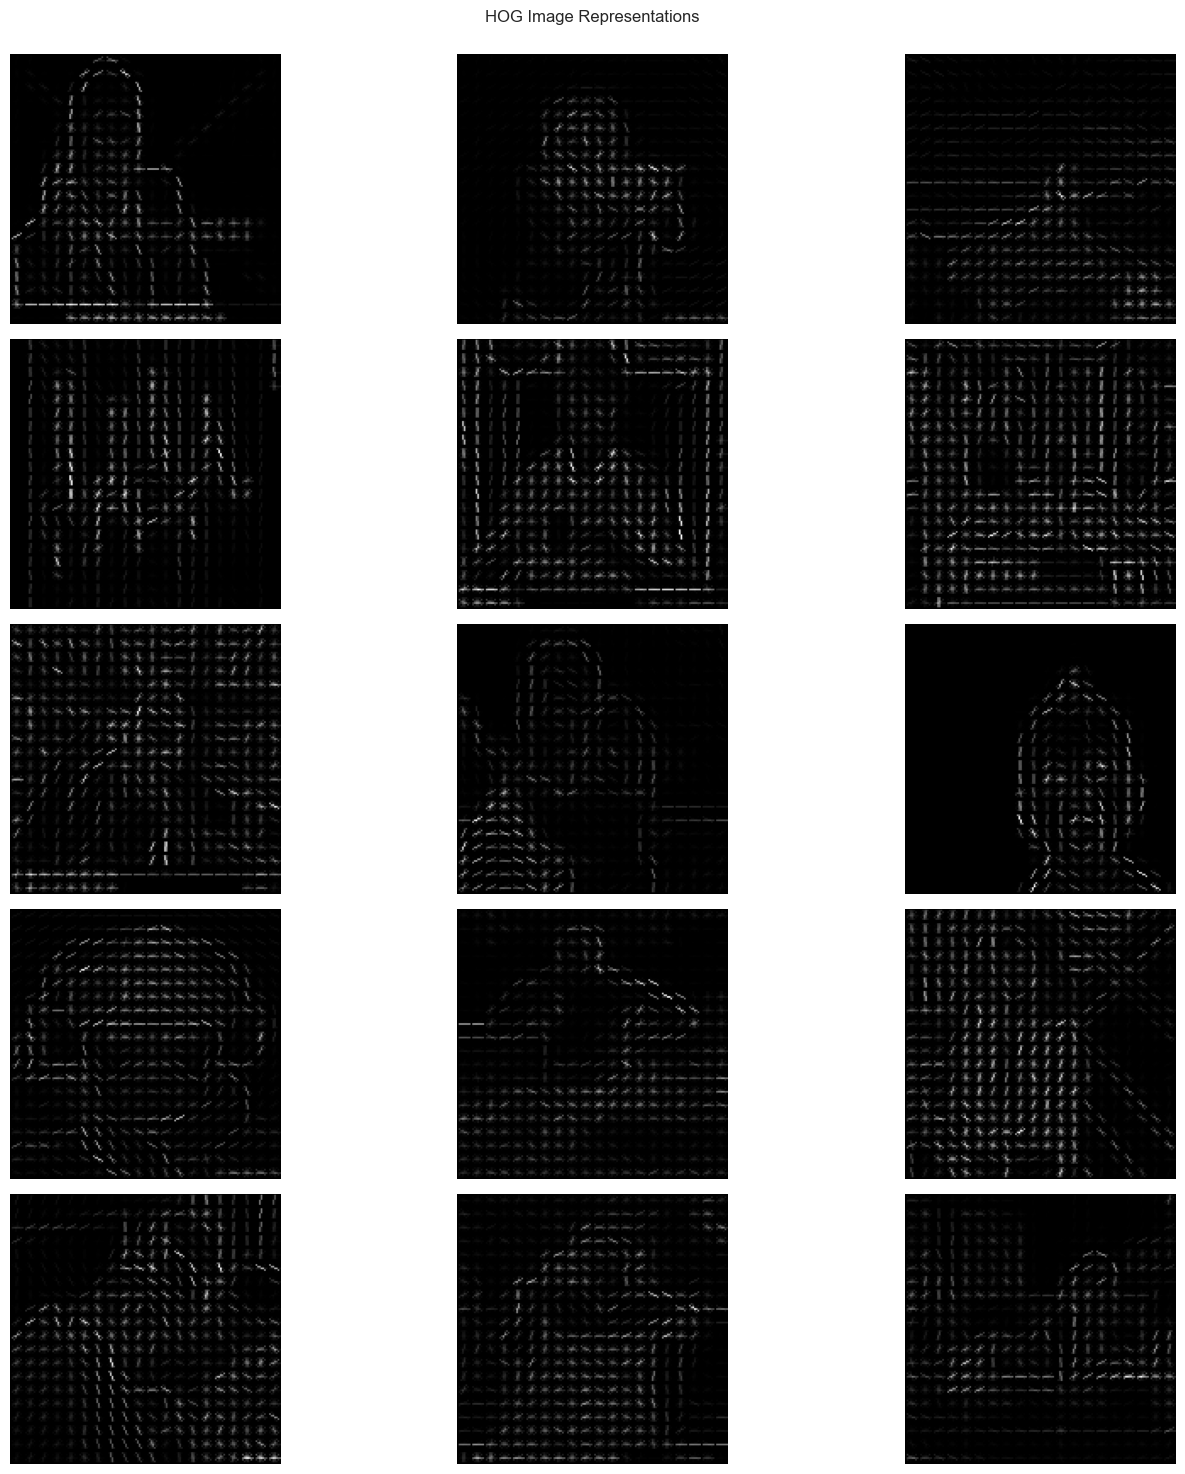

In [60]:
fig, axes = plt.subplots(5, 3, figsize=(15, 15)) 
fig.suptitle('HOG Image Representations')

for idx, img in enumerate(images):
    img_array = np.array(img)
    resized_img = resize(img_array, (160, 160))
    fd, hog_image = hog(resized_img, orientations=9, visualize=True, channel_axis=-1)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    row = idx // 3
    col = idx % 3
    axes[row, col].imshow(hog_image_rescaled, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

We extract HOG features and visualise them. However, we do not use them for training purposes. We do notice that the shape is (160, 160).

### 2. Perform Feature Extraction: Extract relevant features from the images such as Histogram of Oriented Gradients (HOG), color histograms, or other traditional feature extraction methods.

Reference:
- [PyImageSearch: Local Binary Patterns](https://pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/
)

- [GeeksForGeeks: Color Histogram](https://www.geeksforgeeks.org/visualizing-colors-in-images-using-histogram-in-python/)

- [PythonCode: SIFT Feature Extraction](https://thepythoncode.com/article/sift-feature-extraction-using-opencv-in-python)


In [8]:
def extract_lbp_features(image, radius=3, n_points=8*3):
    lbp = local_binary_pattern(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), n_points, radius, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    return lbp_hist

In [9]:
def extract_color_histogram(image, bins=(8, 8, 8)):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv_image], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [10]:
def extract_sift_features(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    _, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is None:
        return np.zeros(128)
    return descriptors.mean(axis=0)

In [11]:
lbp_columns = [f'lbp_{i}' for i in range(26)]
color_columns = [f'color_{i}' for i in range(512)]
sift_columns = [f'sift_{i}' for i in range(128)]

features_df = pd.DataFrame(columns=['height', 'width', 'channels'] + lbp_columns + color_columns + sift_columns, index=label_df.index)

for img_name in label_df['filename']:
    image_path = os.path.join(image_folder, img_name)
    img = cv2.imread(image_path)
    features_df.loc[label_df['filename'] == img_name, 'height'] = img.shape[0]
    features_df.loc[label_df['filename'] == img_name, 'width'] = img.shape[1]
    features_df.loc[label_df['filename'] == img_name, 'channels'] = img.shape[2]
    lbp_features = extract_lbp_features(img)
    features_df.loc[label_df['filename'] == img_name, lbp_columns] = lbp_features
    color_features = extract_color_histogram(img)
    features_df.loc[label_df['filename'] == img_name, color_columns] = color_features    
    sift_features = extract_sift_features(image_path)
    features_df.loc[label_df['filename'] == img_name, sift_columns] = sift_features

label_df = pd.concat([label_df, features_df], axis=1)

In [12]:
label_df.head()

filename         label height width channels     lbp_0     lbp_1  \
0  Image_1.jpg       sitting    160   240        3  0.049974  0.029427   
1  Image_2.jpg  using_laptop    183   275        3  0.039106  0.026508   
2  Image_3.jpg       hugging    183   275        3  0.026329  0.016115   
3  Image_4.jpg      sleeping    183   275        3   0.03688  0.019295   
4  Image_5.jpg  using_laptop    210   240        3  0.039048  0.023214   

      lbp_2     lbp_3     lbp_4  ...   sift_118   sift_119   sift_120  \
0  0.022005  0.016562  0.012891  ...   14.18595  24.535124  26.485537   
1   0.01846  0.012777  0.010075  ...  17.044355  37.516129   27.69758   
2  0.012419  0.011287  0.010631  ...     15.825  37.630001      25.75   
3  0.016672  0.014943  0.012757  ...  15.182724  31.478405  26.548172   
4  0.019008   0.01623  0.015456  ...  16.660378   23.65229  25.625338   

    sift_121   sift_122   sift_123   sift_124   sift_125   sift_126   sift_127  
0  25.146694  19.530993  19.588842  23.913223  14.743802  11.588843   14.67562  
1  18.540323  16.782259  12.334678  16.189516  11.548388   11.57258  16.100807  
2     15.985      12.29     14.895     17.885      11.09      11.55     19.205  
3  26.169436  19.295681  20.823921  22.754152  13.644518  12.019934  15.910299  
4  25.223721  20.191374   22.35849  26.886793  16.619946  13.269542  12.433962  

[5 rows x 671 columns]

We notice that the features extracted using LBP, Color Histogram and SIFT have constant length.

LBP returns a Numpy array of length 26. Color Histogram returns a Numpy array of length 512 and SIFT returns a Numpy array of length 128.

### 3. Model Selection and Implementation:

In [13]:
# Applying label encoding to the label
label_encoder = LabelEncoder()
label_df['label'] = label_encoder.fit_transform(label_df['label'])
label_df.head()

filename  label height width channels     lbp_0     lbp_1     lbp_2  \
0  Image_1.jpg     11    160   240        3  0.049974  0.029427  0.022005   
1  Image_2.jpg     14    183   275        3  0.039106  0.026508   0.01846   
2  Image_3.jpg      7    183   275        3  0.026329  0.016115  0.012419   
3  Image_4.jpg     12    183   275        3   0.03688  0.019295  0.016672   
4  Image_5.jpg     14    210   240        3  0.039048  0.023214  0.019008   

      lbp_3     lbp_4  ...   sift_118   sift_119   sift_120   sift_121  \
0  0.016562  0.012891  ...   14.18595  24.535124  26.485537  25.146694   
1  0.012777  0.010075  ...  17.044355  37.516129   27.69758  18.540323   
2  0.011287  0.010631  ...     15.825  37.630001      25.75     15.985   
3  0.014943  0.012757  ...  15.182724  31.478405  26.548172  26.169436   
4   0.01623  0.015456  ...  16.660378   23.65229  25.625338  25.223721   

    sift_122   sift_123   sift_124   sift_125   sift_126   sift_127  
0  19.530993  19.588842  23.913223  14.743802  11.588843   14.67562  
1  16.782259  12.334678  16.189516  11.548388   11.57258  16.100807  
2      12.29     14.895     17.885      11.09      11.55     19.205  
3  19.295681  20.823921  22.754152  13.644518  12.019934  15.910299  
4  20.191374   22.35849  26.886793  16.619946  13.269542  12.433962  

[5 rows x 671 columns]

In [14]:
# Saving the processed data
label_df.to_csv('processed_data.csv', index = False)

We load already processed and extracted data directly.

In [3]:
label_df = pd.read_csv('processed_data.csv') 

In [4]:
X = label_df.drop(['filename', 'label'], axis=1)
y = label_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_columns = X_train.columns

scaler = MinMaxScaler()

X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [39]:
accuracies = {}

In [ ]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=None, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

In [40]:
y_pred = clf.predict(X_test)

# Evaluate the model
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
accuracies['Random Forest'] = accuracy_score(y_test, y_pred) * 100

Random Forest Accuracy: 36.67%


In [6]:
def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

def load_model(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

In [19]:
save_model(clf, 'random_forest_model.pkl')

In [7]:
clf = load_model('random_forest_model.pkl')

In [8]:
# Testing on loaded model
y_pred = clf.predict(X_test)

print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}")

Random Forest Accuracy: 36.67


In [41]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)

print(f"Naive Bayes Accuracy: {accuracy_score(y_test, y_pred_nb) * 100:.2f}%")
accuracies['Naive Bayes'] = accuracy_score(y_test, y_pred_nb) * 100

Naive Bayes Accuracy: 18.45%


In [42]:
dt_model = DecisionTreeClassifier(random_state=42)

# Fit the model to training data
dt_model.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_model.predict(X_test)

# Print the results
print(f"Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dt) * 100:.2f}%")
accuracies['Decision Tree'] = accuracy_score(y_test, y_pred_dt) * 100

Decision Tree Accuracy: 17.22%


In [43]:
perceptron_model = Perceptron(random_state=42)

# Fit the model to training data
perceptron_model.fit(X_train, y_train)

# Make predictions
y_pred_perceptron = perceptron_model.predict(X_test)

# Print the results
print(f"Perceptron Accuracy: {accuracy_score(y_test, y_pred_perceptron) * 100:.2f}%")
accuracies['Perceptron'] = accuracy_score(y_test, y_pred_perceptron) * 100

Perceptron Accuracy: 17.90%


In [ ]:
%%capture
!pip install xgboost

In [ ]:
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

In [48]:
y_pred_xgb = xgb_model.predict(X_test)

print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb) * 100:.2f}%")
accuracies['XGBoost'] = accuracy_score(y_test, y_pred_xgb) * 100

XGBoost Accuracy: 38.69%


In [29]:
save_model(xgb_model, 'xgboost_model.pkl')

In [9]:
xgb_model = load_model('xgboost_model.pkl')

In [10]:
# On the loaded model
y_pred_xgb = xgb_model.predict(X_test)
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb) * 100:.2f}%")

XGBoost Accuracy: 38.69%


We visualize the model accuracies using a bar plot.

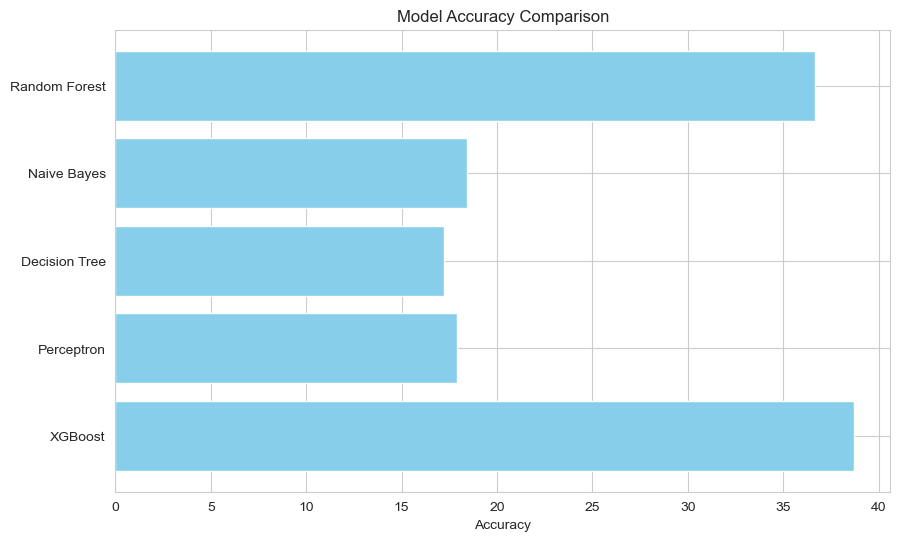

In [52]:
df = pd.DataFrame(list(accuracies.items()), columns=['Model', 'Accuracy'])
plt.figure(figsize=(10, 6))
plt.barh(df['Model'], df['Accuracy'], color='skyblue')
plt.xlabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.gca().invert_yaxis()  # Invert y-axis to show highest accuracy at the top
plt.show()

We notice that Random Forest and XGBoost model provides the highest accuracy and hence, we save these two models in our pickle file.